In [1]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sgpr.gp_regression import GP, SoR, DTC, FITC
from sgpr.gp_utils import RBF

torch.set_default_dtype(torch.float64)

# 実験（4）

* 補助入力点の位置の最適化

## 準備

In [2]:
class Latent_Function():
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level
        self.noise = None

    def _f(self, X):
        # ここを好きにカスタマイズ
        tmp = np.sin(X / 2) + np.cos(X) * 10
        return tmp
    
    def f(self, X, observed=False):
        tmp = self._f(X)

        if observed is True:
            if isinstance(X, np.ndarray):
                noise = np.random.normal(loc=tmp, scale=self.noise_level)
                return noise
            elif isinstance(X, torch.Tensor):
                noise = torch.normal(tmp, self.noise_level)
                return noise
        
        else:
            if isinstance(X, np.ndarray):
                return np.array(tmp)
            elif isinstance(X, torch.Tensor):
                return tmp


def make_data(f, X=None, X_pred=None):
    if X is None:
        X_normal = torch.randn(50) * 1.5 + 4 
        X_normal = torch.clip(X_normal, 0, 10) 
        X_uniform = torch.rand(50) * 6 + 2  
        X_combined = torch.cat([X_normal, X_uniform])
        X, _ = torch.sort(X_combined)
        X = X.reshape(-1, 1)

    y = f(X, observed=True)

    if X_pred is None:
        X_max, X_min = X.max(), X.min()
        interval = torch.abs(X_max - X_min)
        size = int(torch.ceil(interval / 0.1))
        X_pred_max, X_pred_min = X_max + interval * 0.2, X_min - interval * 0.2
        X_pred = torch.linspace(X_pred_min, X_pred_max, size).reshape(-1, 1)

    return X, y, X_pred

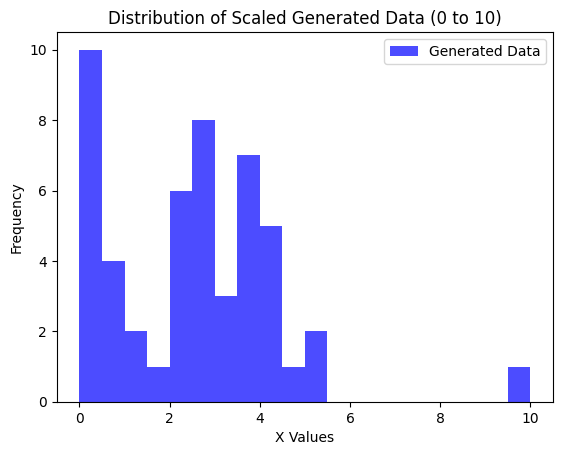

In [3]:
import torch
import matplotlib.pyplot as plt

X_normal = torch.randn(25) * 0.5 + 2
X_normal = torch.clip(X_normal, 0, 5)
X_exponential = torch.exp(torch.randn(25))
X_combined = torch.cat([X_normal, X_exponential])
X_min = X_combined.min()
X_max = X_combined.max()

# スケーリング
scaled_X = (X_combined - X_min) / (X_max - X_min) * 10

X, _ = torch.sort(scaled_X)
generated_X = X.reshape(-1, 1)

plt.hist(X.numpy(), bins=20, color='blue', alpha=0.7, label='Generated Data')
plt.xlabel('X Values')
plt.ylabel('Frequency')
plt.title('Distribution of Scaled Generated Data (0 to 10)')
plt.legend()
plt.show()


FITC
opt_iter: 1/1000
opt_iter: 2/1000
opt_iter: 3/1000
opt_iter: 4/1000
opt_iter: 5/1000
opt_iter: 6/1000
opt_iter: 7/1000
opt_iter: 8/1000
opt_iter: 9/1000
opt_iter: 10/1000
opt_iter: 11/1000
opt_iter: 12/1000
opt_iter: 13/1000
opt_iter: 14/1000
opt_iter: 15/1000
opt_iter: 16/1000
opt_iter: 17/1000
opt_iter: 18/1000
opt_iter: 19/1000
opt_iter: 20/1000
opt_iter: 21/1000
opt_iter: 22/1000
opt_iter: 23/1000
opt_iter: 24/1000
opt_iter: 25/1000
opt_iter: 26/1000
opt_iter: 27/1000
opt_iter: 28/1000
opt_iter: 29/1000
opt_iter: 30/1000
opt_iter: 31/1000
opt_iter: 32/1000
opt_iter: 33/1000
opt_iter: 34/1000
opt_iter: 35/1000
opt_iter: 36/1000
opt_iter: 37/1000
opt_iter: 38/1000
opt_iter: 39/1000
opt_iter: 40/1000
opt_iter: 41/1000
opt_iter: 42/1000
opt_iter: 43/1000
opt_iter: 44/1000
opt_iter: 45/1000
opt_iter: 46/1000
opt_iter: 47/1000
opt_iter: 48/1000
opt_iter: 49/1000
opt_iter: 50/1000
opt_iter: 51/1000
opt_iter: 52/1000
opt_iter: 53/1000
opt_iter: 54/1000
opt_iter: 55/1000
opt_iter: 56/1

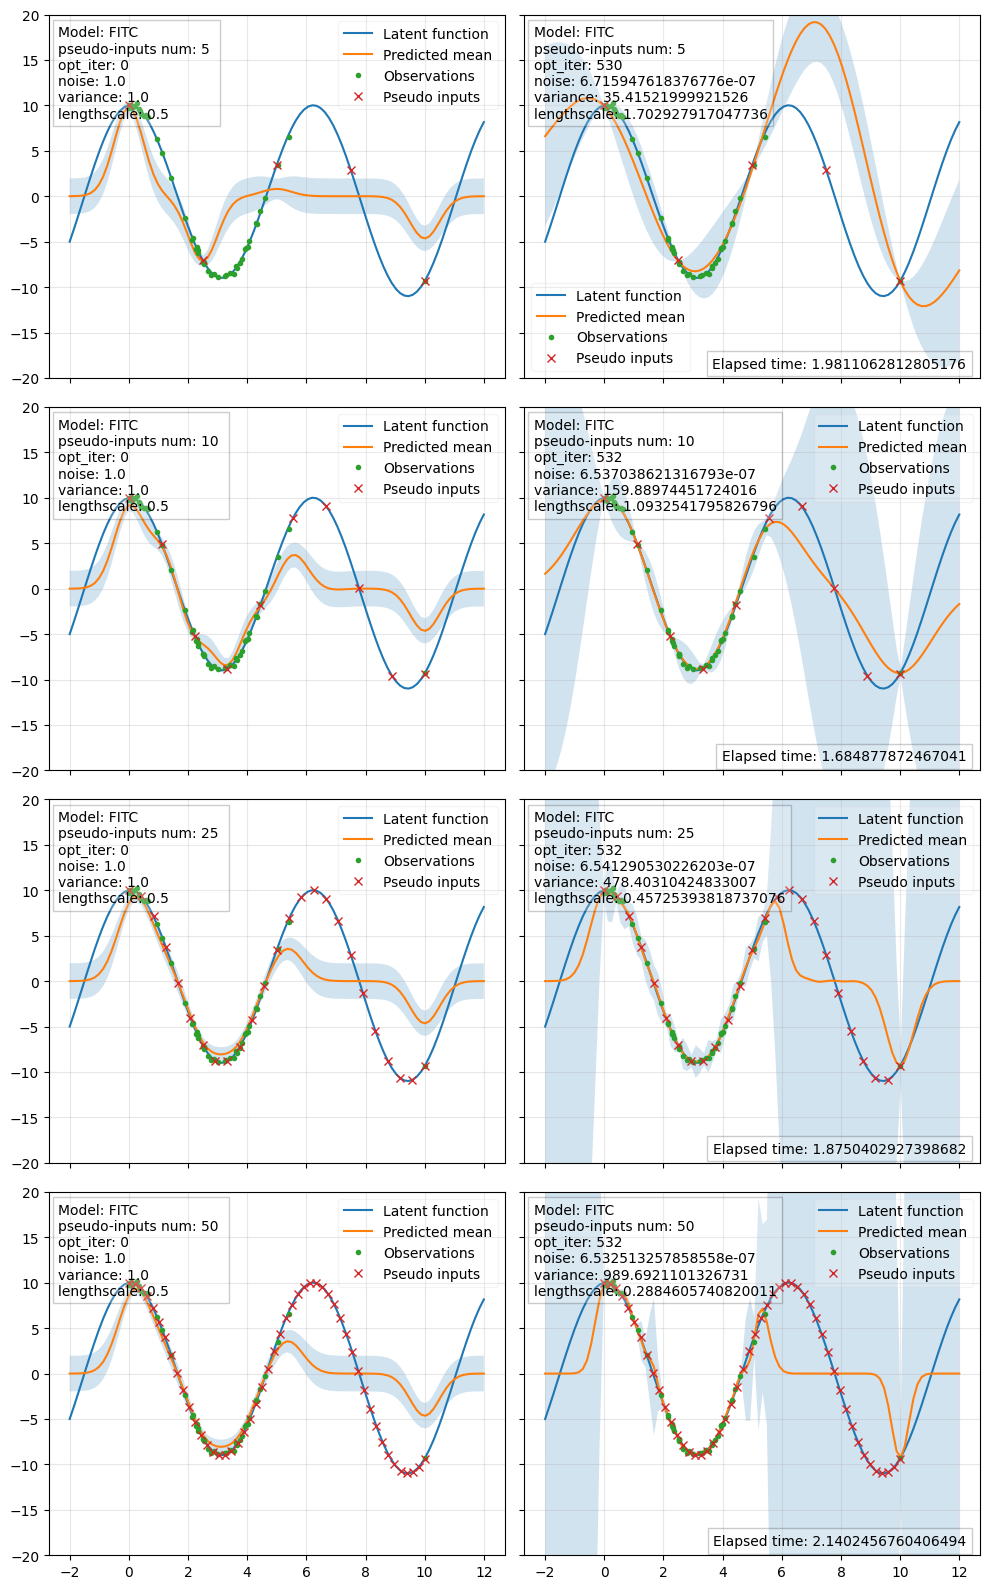

In [4]:
def add_graphs(ax, X, y, X_pred, f, model, mean, cov):
    X = X.ravel().detach().numpy()
    y = y.ravel().detach().numpy()
    X_pred = X_pred.ravel().detach().numpy()
    mean = mean.ravel().detach().numpy()
    var = torch.diagonal(cov).detach().numpy()
    credible_interval = 1.96 * np.sqrt(var) # 95%

    ax.plot(X_pred, f(X_pred), '-', label='Latent function')
    ax.plot(X_pred, mean, '-', label='Predicted mean')
    ax.fill_between(X_pred, mean - credible_interval, mean + credible_interval, alpha=0.2)
    ax.plot(X, y, 'o', alpha=1, ms=3, label='Observations')

    if hasattr(model, "pseudo_inputs"):
        p_inputs = model.pseudo_inputs.ravel().detach().numpy()
        ax.plot(p_inputs, f(p_inputs), 'x', alpha=1, label='Pseudo inputs')

    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)
    ax.legend(fancybox=True, framealpha=0.2)

    text = f'Model: {model.name}\n' \
           f'pseudo-inputs num: {len(model.pseudo_inputs)} \n' \
           f'opt_iter: {len(model.params_opt_results)}\n' \
           f'noise: {np.exp(model.params[0].item())}\n' \
           f'variance: {np.exp(model.params[1].item())}\n' \
           f'lengthscale: {np.exp(model.params[2].item())}' 
    
    ax.text(0.02, 0.97, text, 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.2))


f = Latent_Function(noise_level=0.2).f
X, y, X_pred = make_data(f, generated_X)
models = [FITC]
# models = [GP, SoR, DTC, FITC]
pseudo_inputs_num_list = [5, 10, 25, 50]

include_optimize = True
nrows = len(pseudo_inputs_num_list)
ncols = 1

if include_optimize is True:
    ncols += 1

figsize = (5 * ncols, 4 * nrows)

fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         tight_layout=True, 
                         squeeze=False, 
                         figsize=figsize,
                         sharex=True,
                         sharey=True)


for row, p_inputs_num in enumerate(pseudo_inputs_num_list):
    X, y = X.clone(), y.clone()
    # model = models[row](X, y, p_inputs_num=p_inputs_num)
    model = models[0](X, y, p_inputs_num=p_inputs_num)

    print(model.name)

    for col in range(ncols):
        mean, cov = model.predict(X_pred.clone())
        if col % 2 == 1:
            start_time = time.time()
            model.optimize(iteration=1000, learning_rate=0.01)
            mean, cov = model.predict(X_pred.clone())
            end_time = time.time()
            elapsed_time = end_time - start_time

        ax = axes[row, col]
        add_graphs(ax, X, y, X_pred, f, model, mean, cov)       

        if col % 2 == 1:
            ax.text(0.97, 0.02, f'Elapsed time: {elapsed_time}', 
                    transform=ax.transAxes, 
                    fontsize=10, 
                    verticalalignment='bottom', 
                    horizontalalignment='right', 
                    bbox=dict(facecolor='white', alpha=0.2))

In [28]:
model.make_params_df()

,noise,variance,lengthscale
0,1.000000e+00,1.000000,0.500000
1,9.900498e-01,1.010050,0.505025
2,9.801962e-01,1.020198,0.510093
3,9.704364e-01,1.030445,0.515212
4,9.607682e-01,1.040787,0.520367
...,...,...,...
546,7.504613e-07,2.829340,0.632822
547,7.191449e-07,2.829340,0.632830
548,6.891034e-07,2.829341,0.632838
549,6.602866e-07,2.829341,0.632844


FITC
opt_iter: 1/1000
opt_iter: 2/1000
opt_iter: 3/1000
opt_iter: 4/1000
opt_iter: 5/1000
opt_iter: 6/1000
opt_iter: 7/1000
opt_iter: 8/1000
opt_iter: 9/1000
opt_iter: 10/1000
opt_iter: 11/1000
opt_iter: 12/1000
opt_iter: 13/1000
opt_iter: 14/1000
opt_iter: 15/1000
opt_iter: 16/1000
opt_iter: 17/1000
opt_iter: 18/1000
opt_iter: 19/1000
opt_iter: 20/1000
opt_iter: 21/1000
opt_iter: 22/1000
opt_iter: 23/1000
opt_iter: 24/1000
opt_iter: 25/1000
opt_iter: 26/1000
opt_iter: 27/1000
opt_iter: 28/1000
opt_iter: 29/1000
opt_iter: 30/1000
opt_iter: 31/1000
opt_iter: 32/1000
opt_iter: 33/1000
opt_iter: 34/1000
opt_iter: 35/1000
opt_iter: 36/1000
opt_iter: 37/1000
opt_iter: 38/1000
opt_iter: 39/1000
opt_iter: 40/1000
opt_iter: 41/1000
opt_iter: 42/1000
opt_iter: 43/1000
opt_iter: 44/1000
opt_iter: 45/1000
opt_iter: 46/1000
opt_iter: 47/1000
opt_iter: 48/1000
opt_iter: 49/1000
opt_iter: 50/1000
opt_iter: 51/1000
opt_iter: 52/1000
opt_iter: 53/1000
opt_iter: 54/1000
opt_iter: 55/1000
opt_iter: 56/1

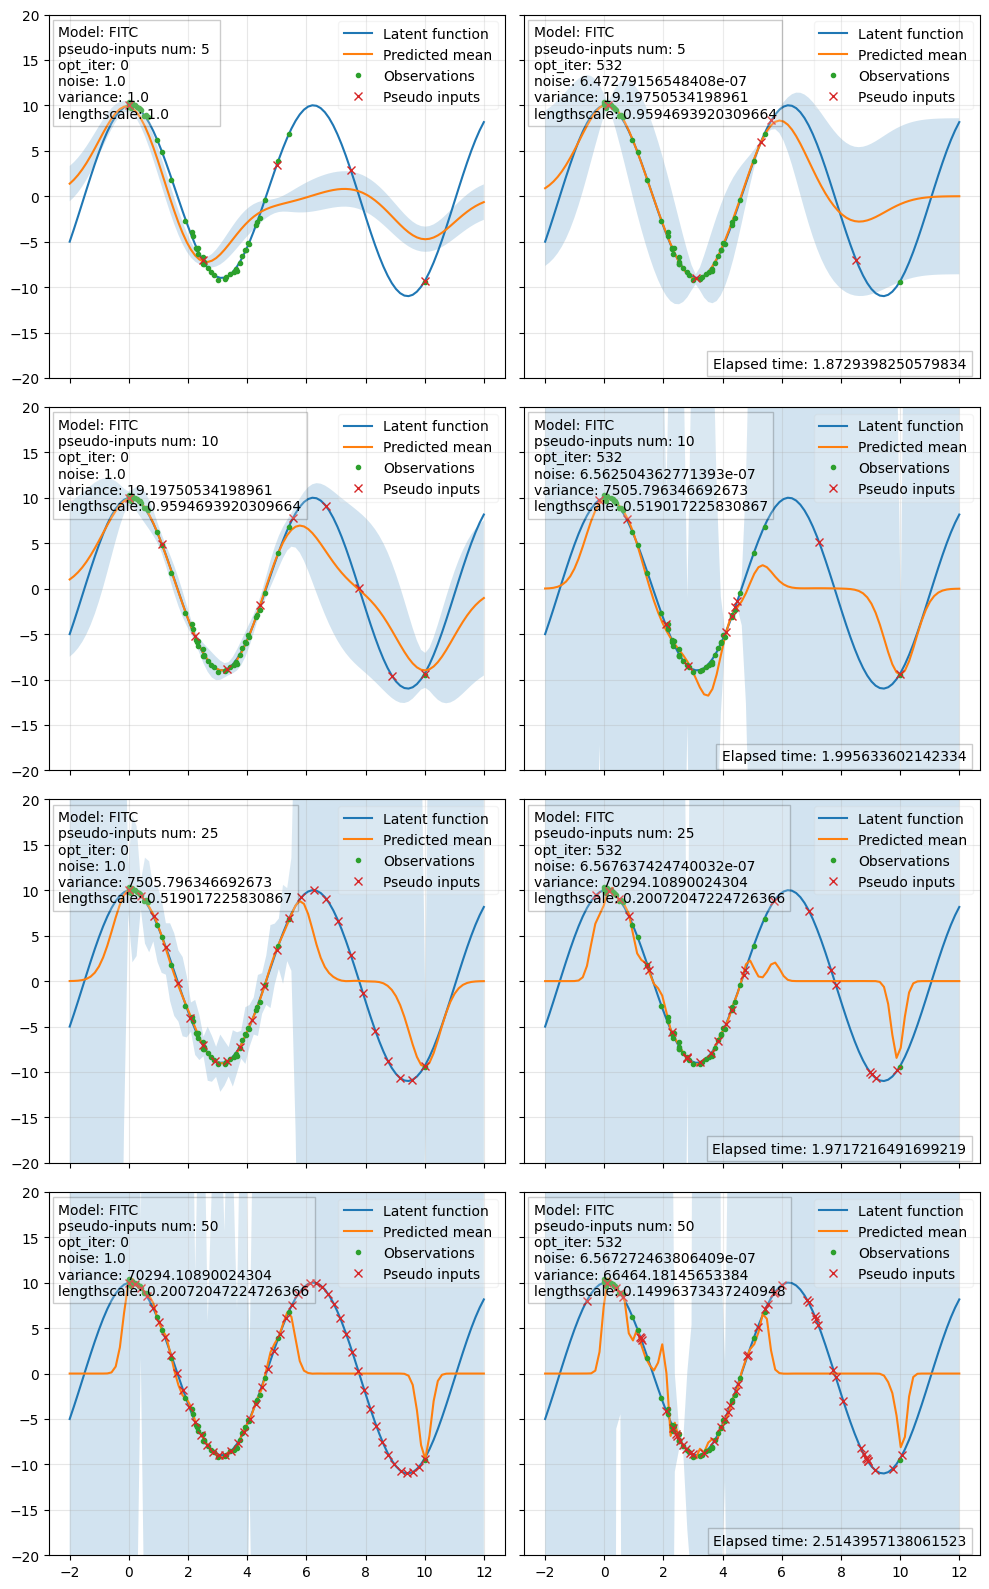

In [9]:
def add_graphs(ax, X, y, X_pred, f, model, mean, cov):
    X = X.ravel().detach().numpy()
    y = y.ravel().detach().numpy()
    X_pred = X_pred.ravel().detach().numpy()
    mean = mean.ravel().detach().numpy()
    var = torch.diagonal(cov).detach().numpy()
    credible_interval = 1.96 * np.sqrt(var) # 95%

    ax.plot(X_pred, f(X_pred), '-', label='Latent function')
    ax.plot(X_pred, mean, '-', label='Predicted mean')
    ax.fill_between(X_pred, mean - credible_interval, mean + credible_interval, alpha=0.2)
    ax.plot(X, y, 'o', alpha=1, ms=3, label='Observations')

    if hasattr(model, "pseudo_inputs"):
        p_inputs = model.pseudo_inputs.ravel().detach().numpy()
        ax.plot(p_inputs, f(p_inputs), 'x', alpha=1, label='Pseudo inputs')

    ax.grid(True, alpha=0.3)
    ax.set_ylim(-20, 20)
    ax.legend(fancybox=True, framealpha=0.2)

    text = f'Model: {model.name}\n' \
           f'pseudo-inputs num: {len(model.pseudo_inputs)} \n' \
           f'opt_iter: {len(model.params_opt_results)}\n' \
           f'noise: {np.exp(model.params[0].item())}\n' \
           f'variance: {np.exp(model.params[1].item())}\n' \
           f'lengthscale: {np.exp(model.params[2].item())}' 
    
    ax.text(0.02, 0.97, text, 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.2))


f = Latent_Function(noise_level=0.2).f
X, y, X_pred = make_data(f, generated_X)
models = [FITC]
# models = [GP, SoR, DTC, FITC]
pseudo_inputs_num_list = [5, 10, 25, 50]
p_optimized = True
kernel_func = RBF(variance=1., lengthscale=1.)

include_optimize = True
nrows = len(pseudo_inputs_num_list)
ncols = 1

if include_optimize is True:
    ncols += 1

figsize = (5 * ncols, 4 * nrows)

fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         tight_layout=True, 
                         squeeze=False, 
                         figsize=figsize,
                         sharex=True,
                         sharey=True)


for row, p_inputs_num in enumerate(pseudo_inputs_num_list):
    X, y = X.clone(), y.clone()
    # model = models[row](X, y, p_inputs_num=p_inputs_num)
    model = models[0](X, y, p_inputs_num=p_inputs_num, p_optimized=p_optimized, kernel=kernel_func)

    print(model.name)

    for col in range(ncols):
        mean, cov = model.predict(X_pred.clone())
        if col % 2 == 1:
            start_time = time.time()
            model.optimize(iteration=1000, learning_rate=0.01)
            mean, cov = model.predict(X_pred.clone())
            end_time = time.time()
            elapsed_time = end_time - start_time

        ax = axes[row, col]
        add_graphs(ax, X, y, X_pred, f, model, mean, cov)       

        if col % 2 == 1:
            ax.text(0.97, 0.02, f'Elapsed time: {elapsed_time}', 
                    transform=ax.transAxes, 
                    fontsize=10, 
                    verticalalignment='bottom', 
                    horizontalalignment='right', 
                    bbox=dict(facecolor='white', alpha=0.2))

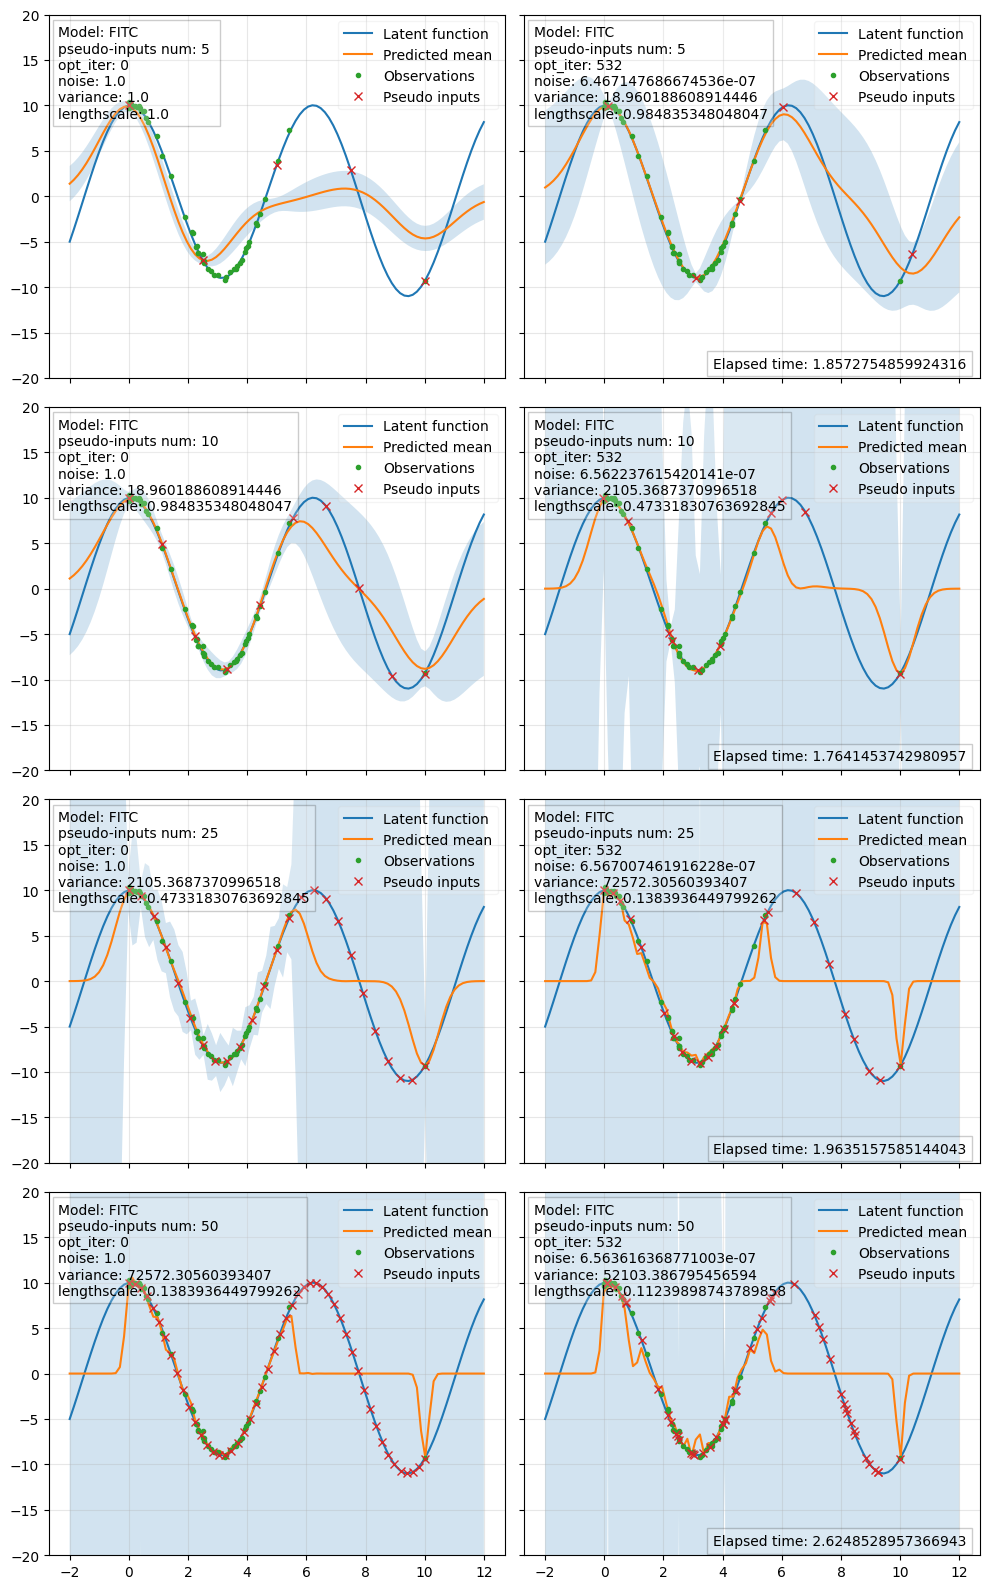